# Mean Plane Stereoplot and Rose diagram of dip directions

#### Calculates the mean orientation of a given set of data (planes or lineations). Untilts data according to bedding orientation

Input: Excel (XLS, XLSX) or text (TXT, CSV) file with the orientation of data. Data can be either Lines (azimuth and plunge) or Planes (Strike and Dip in right-hand rule format).

First row should contain headings.

Output: Vector Statistics (Mean and standard deviation), Stereonet plots and Rose diagrams.

Requirements: module mplstereonet. Credits to: http://geologyandpython.com/structural_geology.html

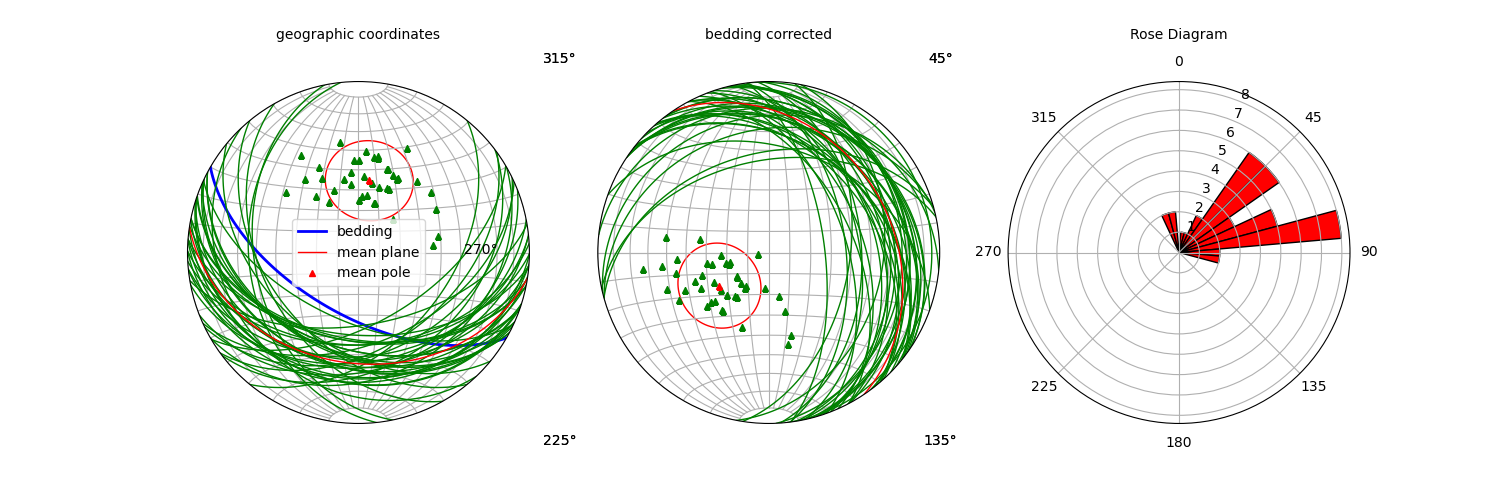

In [1]:
import numpy as np
import pandas as pd # and of course Pandas
import matplotlib.pyplot as plt
import mplstereonet
import ipywidgets as widgets

#%matplotlib inline
class color:
   RED = '\033[91m'
   BOLD = '\033[1m'
   END = '\033[0m'

In [2]:
def dir2cart(d):
    """
    Converts a list or array of vector directions in degrees (declination,
    inclination) to an array of the direction in cartesian coordinates (x,y,z)
    Parameters
    d : list or array of [dec,inc] or [dec,inc,intensity]
    Returns
    cart : array of [x,y,z]
    Examples
    >>> pmag.dir2cart([200,40,1])
    array([-0.71984631, -0.26200263,  0.64278761])
    """
    ints = np.ones(len(d)).transpose(
    )  # get an array of ones to plug into dec,inc pairs
    d = np.array(d)
    rad = np.pi/180.
    if len(d.shape) > 1:  # array of vectors
        decs, incs = d[:, 0] * rad, d[:, 1] * rad
        if d.shape[1] == 3:
            ints = d[:, 2]  # take the given lengths
    else:  # single vector
        decs, incs = np.array(float(d[0])) * rad, np.array(float(d[1])) * rad
        if len(d) == 3:
            ints = np.array(d[2])
        else:
            ints = np.array([1.])
    cart = np.array([ints * np.cos(decs) * np.cos(incs), ints *
                     np.sin(decs) * np.cos(incs), ints * np.sin(incs)]).transpose()
    return cart

def cart2dir(cart):
    """
    Converts a direction in cartesian coordinates into declination, inclinations
    Parameters
    cart : input list of [x,y,z] or list of lists [[x1,y1,z1],[x2,y2,z2]...]
    Returns
    direction_array : returns an array of [declination, inclination, intensity]
    Examples
    >>> pmag.cart2dir([0,1,0])
    array([ 90.,   0.,   1.])
    """
    cart = np.array(cart)
    rad = np.pi / 180.  # constant to convert degrees to radians
    if len(cart.shape) > 1:
        Xs, Ys, Zs = cart[:, 0], cart[:, 1], cart[:, 2]
    else:  # single vector
        Xs, Ys, Zs = cart[0], cart[1], cart[2]
    if np.iscomplexobj(Xs):
        Xs = Xs.real
    if np.iscomplexobj(Ys):
        Ys = Ys.real
    if np.iscomplexobj(Zs):
        Zs = Zs.real
    Rs = np.sqrt(Xs**2 + Ys**2 + Zs**2)  # calculate resultant vector length
    # calculate declination taking care of correct quadrants (arctan2) and
    # making modulo 360.
    Decs = (np.arctan2(Ys, Xs) / rad) % 360.
    try:
        # calculate inclination (converting to degrees) #
        Incs = np.arcsin(Zs/Rs) /rad
    except:
        print('trouble in cart2dir')  # most likely division by zero somewhere
        return np.zeros(3)

    return np.array([Decs, Incs, Rs]).transpose()  # return the directions list

def untilt(geo_di, axis_azimuth, rot_angle):
    """
    Rotates vectors about a horizontal rotation axis and (rot_angle: + clockwise, - counterclockwise)
    
    Parameters:
    geo_di : input list of [dec, inc] or list of lists [[dec1,inc1],[dec2,inc2]...]
    axis_azimuth: azimuth of horizontal rotation axis
    rot_angle: angle of rotation about the horizontal axis
    Returns:
    direction_array : returns an array of rotated vectors[declination, inclination]
    """
    #change geographic coordinates to bedding-strike coordinates (SEE FIGURE BELOW)
    #(N--> bedding strike, E --> dipdir). returning unit vectors
    geo_cart =dir2cart(geo_di)         #returns cartesian coordinates of polar directions [N,E,down]
    strike_coord_cart =np.array([np.sqrt(np.square(geo_cart[:,0])+np.square(geo_cart[:,1]))
                                 *np.cos(np.radians(geo_di[:,0]-axis_azimuth)),               # BEDDING-STRIKE COORDINATE
                            np.sqrt(np.square(geo_cart[:,0])+np.square(geo_cart[:,1]))
                                 *np.sin(np.radians(geo_di[:,0]-axis_azimuth)),               #DIP-DIR COORDINATE
                            geo_cart[:,2]]                                                    # Zdown COORDINATE
                               ).transpose()
    #rotate about the axis
    strike_coord_cart_rotated = np.array([strike_coord_cart[:,0],
                            np.cos(np.arctan2(strike_coord_cart[:,2],strike_coord_cart[:,1])+np.radians(rot_angle))*np.sqrt(np.square(strike_coord_cart[:,1])+ np.square(strike_coord_cart[:,2])),
                            np.sin(np.arctan2(strike_coord_cart[:,2],strike_coord_cart[:,1])+np.radians(rot_angle))*np.sqrt(np.square(strike_coord_cart[:,1])+ np.square(strike_coord_cart[:,2]))]).transpose()
    strike_coord_di_rotated = cart2dir(strike_coord_cart_rotated)   #returns polar coord of cartesian coord [dec, inc]
    #return to geographic coordinates [North,East,Down]
    geo_di_rotated = strike_coord_di_rotated                                                                                                      
    geo_di_rotated[:,0] = geo_di_rotated[:,0]+axis_azimuth
    #np.round(geo_di_rotated[:,:2])
    return geo_di_rotated[:,:2]




Changing coordinate system from N(Y)-East(X) coordinates to Strike(Y')- DipDir (X') coordinates
<div>
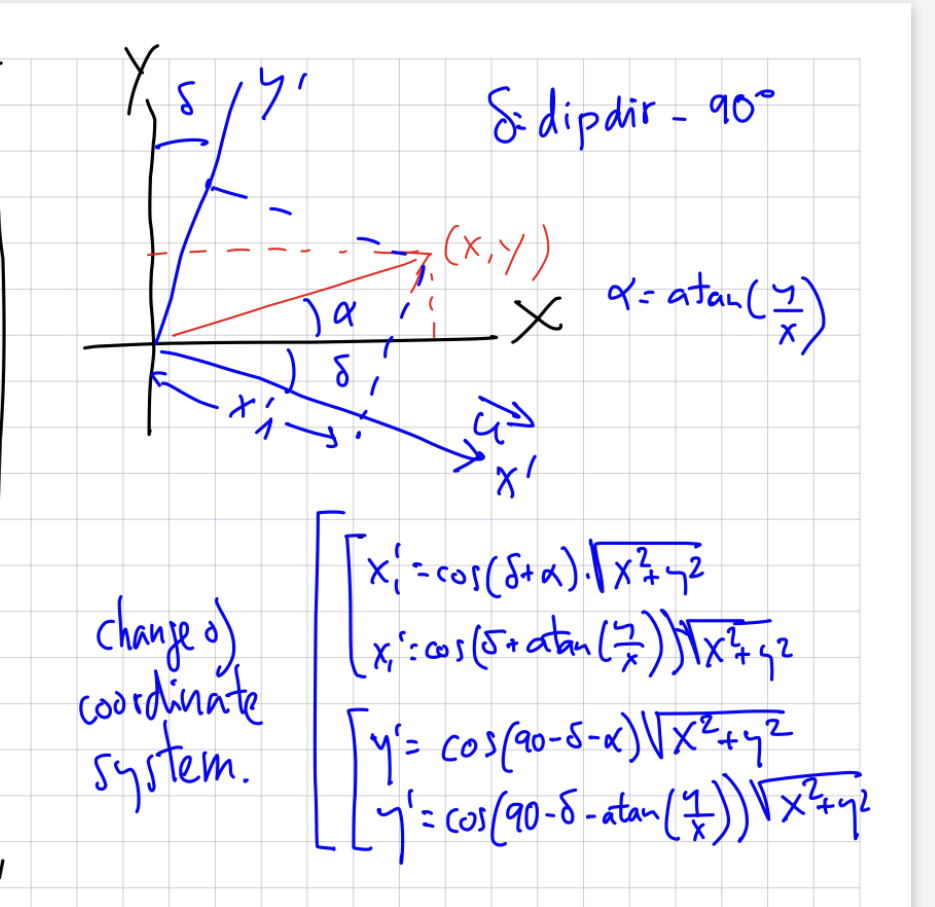
</div>

In [3]:
# 3D Vector statistics
def vector_statistics(di_array):
    '''
    Calculates the mean vector and standard deviation of a set of vectors
    Parameters:
    array of strikes and dip pairs: array([[102,45],[020,34],...])
    
    returns an array of mean_strike, mean_plunge, intensity, and standard deviation
    '''
    N = len(di_array)                          # N number of vectors
    vectors = di_array
    ones = np.full((N, 1), int(1))
    vectors = np.append(vectors, ones, axis = 1)
    
    # From strike-dip to Cartesian coordinates
    vectors_cartesian_coord = dir2cart(vectors)
    Xcoord, Ycoord, Zcoord = vectors_cartesian_coord[:,0],vectors_cartesian_coord[:,1],vectors_cartesian_coord[:,2]


    # Calculate the mean pole
    mean_vector_cartesian = np.array([Xcoord.sum(),Ycoord.sum(),Zcoord.sum()])
    mean_vector = cart2dir(mean_vector_cartesian).round(1)
   
    #Calculate standard deviation
    mean_vector_cartesian/=np.linalg.norm(mean_vector_cartesian) #mean unit vector
    sumatori = 0
    for n in range(N):
        m = (2*np.arcsin(np.sqrt((Xcoord[n]-mean_vector_cartesian[0])**2+
                           (Ycoord[n]-mean_vector_cartesian[1])**2+
                           (Zcoord[n]-mean_vector_cartesian[2])**2)/2))**2
        sumatori += m
    std_dev = np.degrees(np.sqrt(sumatori/N)).round(1)
    return(mean_vector,std_dev)

### Select input file

In [4]:
from tkinter import *
from tkinter import filedialog
# Create Tk root
root = Tk()
# Hide the main window
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)

filename = filedialog.askopenfilename(filetypes = (('excel XLSX', '*.xlsx'),('excel XLS', '*.xls'),
                                                  ('text (TAB separated)','*.txt'),
                                                  ('csv (comma separated)', '*.csv'))) 
print(filename)
if filename[-4:] == '.txt':
    data = pd.read_csv(filename, sep="\t")
if filename[-4:] == '.csv':
    data = pd.read_csv(filename)
elif filename[-4:] in (".xls", "xlsx"):
    data = pd.read_excel(filename)
data.head()
#data.info()

C:/Users/Miguel/OneDrive - Universitat de Barcelona/projects/Almazan compartit/Camp Sept 2024/fieldmove/project23.fm/plane.csv


,localityId,localityName,dataId,x,y,latitude,longitude,zone,altitude,horiz_precision,vert_precision,planeType,dip,dipAzimuth,strike,declination,rockUnit,timedate,notes
0,82e9841922a6e1da97b69505035482ec,Miñana,696ded5a485f464d4fa67db79bc4d4bb,575893.808637,4.598721e+06,41.536549,-2.090180,30T,1006.8,5.0,9.5,Bedding,66.0,226.0,136.0,0.844,Unit 1,Fri Sep 20 12:33:37 2024,
1,82e9841922a6e1da97b69505035482ec,Miñana,db0abbb42a26e11a01cd12327e794ab7,575874.311300,4.598703e+06,41.536380,-2.090416,30T,1006.8,5.0,9.5,Bedding,60.0,226.0,136.0,0.844,Unit 1,Fri Sep 20 12:33:05 2024,
2,82e9841922a6e1da97b69505035482ec,Miñana,ec520e53eb9ee511c34195b453a2a57d,575862.553583,4.598679e+06,41.536172,-2.090560,30T,1006.8,5.0,9.5,Bedding,61.0,238.0,148.0,0.844,Unit 1,Fri Sep 20 12:32:43 2024,
3,82e9841922a6e1da97b69505035482ec,Miñana,f5c0c00142c6453274cb99fc4e15fc5c,575858.497061,4.598700e+06,41.536357,-2.090606,30T,1006.8,5.0,9.5,Bedding,64.0,222.0,132.0,0.844,Unit 1,Fri Sep 20 12:32:07 2024,
4,82e9841922a6e1da97b69505035482ec,Miñana,95eeaabe4f5f2503eb069dabd75748f1,575856.007601,4.598692e+06,41.536283,-2.090637,30T,1006.8,5.0,9.5,Bedding,58.0,227.0,137.0,0.844,Unit 1,Fri Sep 20 12:31:23 2024,


### Select data

In [5]:
# Selecting the column in the dataframe that contains the dataset
#len(data.columns)
columns = data.columns.tolist()
data_type = widgets.Dropdown(options = ['Planes','Lineations'], description='data type')
box_1 = widgets.Box([data_type])

data_strike = widgets.Dropdown(options = columns, description='strike')
data_dip = widgets.Dropdown(options = columns, description='plunge')
box_2 = widgets.Box([data_strike,data_dip])

SenseFlow = widgets.Checkbox(value = True, description = 'Lines indicate sense of flow')


box_SecondaryData = widgets.VBox([box_1, box_2, SenseFlow])

# Set bedding orientation for restoration of data
label = widgets.Label('Set Bedding orientation:')
bedding_strike = widgets.BoundedFloatText(value=0, min=0, max=360, step=1, description='strike:', disabled=False)
bedding_dip = widgets.BoundedFloatText(value=0, min=0, max=90, step=1, description='dip:', disabled=False)
box_bedding = widgets.Box([label, bedding_strike,bedding_dip])

display(box_SecondaryData, box_bedding)

Box(children=(Label(value='Set Bedding orientation:'), BoundedFloatText(value=0.0, description='strike:', max=…

### Statistics

In [6]:
#STATISTICS IN GEOGRAPHIC COORDINATES

strike = np.array([data[data_strike.value]])
dip = np.array([data[data_dip.value]])
N = len(strike[0])

if data_type.value == 'Lineations':
    #Calculate the mean lineation
    lineations = np.append(strike,dip, axis =0).T
    mean_lineation, stdev = vector_statistics(lineations)

elif data_type.value == 'Planes':
    #Calculate the mean pole
    pole_strike = strike+270
    pole_plunge = 90- dip
    poles = np.append(pole_strike,pole_plunge, axis =0).T
    mean_pole, stdev = vector_statistics(poles)

    # Calculate the mean plane
    mean_plane = np.array([mean_pole[0]+90,90-mean_pole[1]]).round(1)
    if mean_pole[0] > 270:
        mean_plane = np.array([mean_pole[0]-270,90-mean_pole[1]]).round(1)
    else:
        pass
else:
    print(color.RED + color.BOLD + 'SOMETHING WENT WRONG'.format()+ color.END)



#STATISTICS IN BEDDING COORDINATES

if data_type.value == 'Lineations':
    # untilting lineations
    lines_untilted = untilt(lineations,bedding_strike.value,-bedding_dip.value)  #lineations corrected for bedding tilt
    # mean lineation
    untilted_mean_lineation, untilted_stdev = vector_statistics(lines_untilted)
    
    #Calculate the mean azimuth of lineations (for use in rose diagram)
    dipdir = lines_untilted.T[0] # Get dip direction from the strike  (right hand rule applied)
    zeros = np.full((N, 1), int(0))
    azimuths = np.append(np.array([dipdir]).T,zeros, axis =1)
    azimuth_stats = vector_statistics(azimuths)
    mean_azimuth = azimuth_stats[0][0]
    azimuth_std_dev = azimuth_stats[1]
    
elif data_type.value == 'Planes':
    # untilting poles
    poles_untilted = untilt(poles,bedding_strike.value,-bedding_dip.value)  #poles corrected for bedding tilt
    for n in range(N):                                    #correct for azimiths larger than 360
            if poles_untilted[n][0]>360: 
                poles_untilted[n][0] = poles_untilted[n][0] - 360
            else:
                pass
    # mean pole
    untilted_mean_pole, untilted_stdev = vector_statistics(poles_untilted)

    # untilted planes
    untilted_planes_strike = poles_untilted.T[0]+90                   #get plane strike from pole 
    for n in range(N):
        if untilted_planes_strike[n]>360:
            untilted_planes_strike[n] = untilted_planes_strike[n] - 360
        else:
            pass
    untilted_planes_dip = 90 - poles_untilted.T[1]                    #get plane dip from pole 

    # mean plane from pole
    untilted_mean_plane = np.array([untilted_mean_pole[0]+90,90-untilted_mean_pole[1]]).round(1)
    if untilted_mean_plane[0] > 360:
        untilted_mean_plane[0] = untilted_mean_plane[0]- 360
    else:
        pass

    #Calculate the mean azimuth of dip directions
    dipdir = (untilted_planes_strike+90) # Get dip direction from the strike of planes (right hand rule applied)
    zeros = np.full((N, 1), int(0))
    azimuths = np.append(np.array([dipdir]).T,zeros, axis =1)
    azimuth_stats = vector_statistics(azimuths)
    mean_azimuth = azimuth_stats[0][0]
    azimuth_std_dev = azimuth_stats[1]

else:
    print(color.RED + color.BOLD + 'SOMETHING WENT WRONG'.format()+ color.END)

#Summary statistics
if data_type.value == 'Lineations':
    statistics = [[N, mean_lineation[0], mean_lineation[1],
                   untilted_mean_lineation[0], untilted_mean_lineation[1], stdev, mean_azimuth, azimuth_std_dev]]
    df_stats = pd.DataFrame(statistics, index = ['Lineations'],
                            columns =['N', 'STRIKE g', 'PLUNGE g','STRIKE s', 'PLUNGE s', 'standard dev',
                                      'mean azimuth','standard dev'])
    df_stats.round(1)
    
elif data_type.value == 'Planes':
    statistics = [[N, mean_plane[0],mean_plane[1],
                   untilted_mean_plane[0],untilted_mean_plane[1], stdev, mean_azimuth, azimuth_std_dev]]
    df_stats = pd.DataFrame(statistics, index = ['Planes'],
                            columns =['N', 'STRIKE g', 'DIP g','STRIKE s', 'DIP s','standard dev',
                                      'mean azimuth','standard dev'])
    df_stats.round(1)    

### Plotting

,N,STRIKE g,DIP g,STRIKE s,DIP s,standard dev,mean azimuth,standard dev
Planes,10,139.4,60.9,139.4,60.9,6.0,229.4,4.9


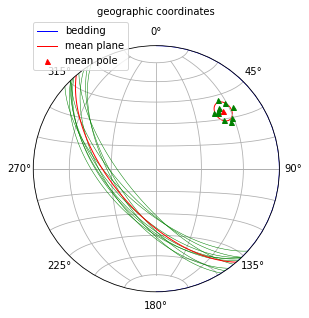

In [8]:
#Plot data on stereonet
fig = plt.figure(figsize=(15, 5))
#first stereoplot
strike_array = strike[0]
dip_array = dip[0]
ax1 = fig.add_subplot(131, projection='stereonet')
ax1.plane(bedding_strike.value, bedding_dip.value, 'b', linewidth=1, label='bedding')

if data_type.value == 'Lineations':
    ax1.line(dip_array, strike_array, color="black", markersize=4)                                      #(plunge, strike)
    if mean_lineation[1]>0:
        ax1.line(mean_lineation[1], mean_lineation[0], color="red", markersize=6, label = 'mean lineation') #(plunge, strike)
        ax1.cone(mean_lineation[1], mean_lineation[0], stdev, color ='red', facecolor='none')
    else:
        ax1.line(-mean_lineation[1], mean_lineation[0], color="grey", markersize=6, label = 'mean lineation') #(plunge, strike)
        ax1.cone(-mean_lineation[1], mean_lineation[0], stdev, color ='grey', facecolor='none')
        
    UpHem_lineations = lineations[lineations.T[1]<0]
    ax1.line(-UpHem_lineations.T[1], UpHem_lineations.T[0], color="grey", markersize=4)

elif data_type.value == 'Planes':
    ax1.plane(strike_array, dip_array, 'g-', linewidth=0.5)
    ax1.plane(mean_plane[0],mean_plane[1],'r-',linewidth=1, label = 'mean plane')
    ax1.cone(mean_pole[1],mean_pole[0],stdev,color='red', facecolor='none') #plunge, bearing, angle(radius) of semicone
    ax1.pole(strike_array, dip_array, 'g^', markersize=5)
    ax1.pole(mean_plane[0],mean_plane[1], 'r^', markersize=5, label='mean pole')
ax1.grid()
ax1.legend(loc= (0,0.9))
ax1.set_title('geographic coordinates', y=1.10, fontsize=10)

#second stereoplot
ax2 = fig.add_subplot(132, projection='stereonet')

if data_type.value == 'Lineations':
    ax2.line(lines_untilted.T[1], lines_untilted.T[0], color="black", markersize=4)     #(plunge, strike)
    
    if untilted_mean_lineation[1]>0:
        ax2.line(untilted_mean_lineation[1], untilted_mean_lineation[0], color="red", markersize=6, label = 'mean lineation')     #(plunge, strike)
        ax2.cone(untilted_mean_lineation[1], untilted_mean_lineation[0], untilted_stdev, color ='red', facecolor='none')
    else:
        ax2.line(-untilted_mean_lineation[1], untilted_mean_lineation[0], color="grey", markersize=6, label = 'mean lineation') #(plunge, strike)
        ax2.cone(-untilted_mean_lineation[1], untilted_mean_lineation[0], stdev, color ='grey', facecolor='none')

    UpHem_lines_untilted = lines_untilted[lines_untilted.T[1]<0]
    ax2.line(-UpHem_lines_untilted.T[1], UpHem_lines_untilted.T[0], color="grey", markersize=4)


elif data_type.value == 'Planes':
    ax2.plane(untilted_planes_strike, untilted_planes_dip, 'g-', linewidth=0.5)
    ax2.pole(untilted_planes_strike, untilted_planes_dip, 'g^', markersize=5)
    ax2.plane(untilted_mean_plane[0],untilted_mean_plane[1],'r-',linewidth=1, label = 'mean plane')    #strike, dip of plane
    ax2.pole(untilted_mean_plane[0],untilted_mean_plane[1], 'r^', markersize=5, label='mean pole')     #strike, dip of plane
    ax2.cone(untilted_mean_pole[1],untilted_mean_pole[0],untilted_stdev,color='red', facecolor='none') #plunge, bearing, angle(radius) of semicone

ax2.grid()
ax2.legend(loc= (0,0.9))
ax2.set_title('bedding corrected', y=1.10, fontsize=10)


#Plotting Rose diagram
# Flip directions if sense of flow not known  
if SenseFlow.value == False:      #ADD to paleocurrent data the antipodal vectors
    antipodal_dipdir = dipdir + 180
    data_to_plot = np.append(dipdir,antipodal_dipdir)
    print(color.RED + color.BOLD+ 'Adding antipodal vectors to rose diagram')

else:
    data_to_plot = dipdir

for a in range(len(data_to_plot)):    # correct azimuths to range between 0º and 360º
    if data_to_plot[a] > 360:
        data_to_plot[a] = data_to_plot[a]-360
    else:
        pass

      
bin_edges = np.arange(-5, 366, 10)   # HERE THE NUMBER OF BINS CAN BE SET (start bin azimut, end bin azimuth, bininterval)
number_of_data, bin_edges = np.histogram(data_to_plot, bin_edges)  # Calculate the number of directions (strikes) every 10° using numpy.histogram.
number_of_data[0] += number_of_data[-1]  # Sum the last value with the first value
number_of_data = number_of_data[:-1]

ax3 = fig.add_subplot(133, projection='polar')
ax3.bar(np.deg2rad(np.arange(0, 360, 10)), number_of_data, 
       width=np.deg2rad(10), bottom=0.0, color='sandybrown', edgecolor='sandybrown')
ax3.set_theta_zero_location('N')
ax3.set_theta_direction(-1)
ax3.set_thetagrids(np.arange(0, 360, 10))
ax3.set_thetagrids(np.arange(0, 360, 10), labels=np.arange(0, 360, 10))
#ax3.set_rgrids(np.arange(1, number_of_strikes.max() + 1, 2), angle=0, weight= 'black')
ax3.set_title('Rose Diagram', y=1.10, fontsize=10)

fig.savefig('my_stereonet.jpg')
#plt.show()
df_stats

In [8]:
display(box_SecondaryData)
display(box_bedding)

Box(children=(Label(value='Set Bedding orientation:'), BoundedFloatText(value=0.0, description='strike:', max=…

### Export Data

In [9]:
#df_stats.to_excel("mean bedding.xlsx")

In [10]:
#pd.DataFrame(dipdir, columns=['azimuth']).to_csv('results.csv', index=False)